# DSA5105 Individual Project
### -- Zhang Youyang (A0251290M)

In this notebook, machine learning models will be trained to predict housing prices in Merbourne, Australia. The model with highest score will be selected as the final model and could be used to predict housing price in the future.
<br>
The dataset is downloaded from Kaggle: <a href="https://www.kaggle.com/datasets/dansbecker/melbourne-housing-snapshot?select=melb_data.csv">Melbourne Housing Snapshot</a>.

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np

from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn import metrics

from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

from sklearn.decomposition import PCA, KernelPCA

import warnings
warnings.filterwarnings('ignore')

ImportError: dlopen(/Users/youyangzhang/Library/Python/3.10/lib/python/site-packages/tensorflow/python/platform/_pywrap_cpu_feature_guard.so, 0x0002): tried: '/Users/youyangzhang/Library/Python/3.10/lib/python/site-packages/tensorflow/python/platform/_pywrap_cpu_feature_guard.so' (mach-o file, but is an incompatible architecture (have (arm64), need (x86_64)))

In [2]:
sns.set_theme()

## 1. Data Description
The original data contains 13580 rows and 21 columns which consist of 20 predictor variables and one target variable, <b>Price</b>. Predictor variables includes <b>the number of rooms, housing types, distance from CBD, landsize, and so on</b>.

In [3]:
# Import Data from current directory
df = pd.read_csv('melb_data.csv')

# Categorical Data
df['Suburb'] = df['Suburb'].astype('category')
df['Postcode'] = df['Postcode'].astype('category')
df['Regionname'] = df['Regionname'].astype('category')
df['SellerG'] = df['SellerG'].astype('category')
df['Type'] = df['Type'].astype('category')
df['Method'] = df['Method'].astype('category')
df['Address'] = df['Address'].astype('category')


# Numerical Data
df['Rooms'] = df['Rooms'].astype('int64')
df['Bathroom'] = df['Bathroom'].astype('int64')
df['Car'] = df['Car'].fillna(0) 
df['Car'] = df['Car'].astype('int64')
df['Price_in_millions'] = df['Price'] / 1000000

# Date Data
df['Date'] = pd.to_datetime(df['Date'])

# Drop poorly sourced columns
df = df.drop(columns=['BuildingArea', 'YearBuilt', 'CouncilArea', 'Bedroom2', 'Price'])

df.head()

,Suburb,Address,Rooms,Type,Method,SellerG,Date,Distance,Postcode,Bathroom,Car,Landsize,Lattitude,Longtitude,Regionname,Propertycount,Price_in_millions
0,Abbotsford,85 Turner St,2,h,S,Biggin,2016-03-12,2.5,3067.0,1,1,202.0,-37.7996,144.9984,Northern Metropolitan,4019.0,1.480
1,Abbotsford,25 Bloomburg St,2,h,S,Biggin,2016-04-02,2.5,3067.0,1,0,156.0,-37.8079,144.9934,Northern Metropolitan,4019.0,1.035
2,Abbotsford,5 Charles St,3,h,SP,Biggin,2017-04-03,2.5,3067.0,2,0,134.0,-37.8093,144.9944,Northern Metropolitan,4019.0,1.465
3,Abbotsford,40 Federation La,3,h,PI,Biggin,2017-04-03,2.5,3067.0,2,1,94.0,-37.7969,144.9969,Northern Metropolitan,4019.0,0.850
4,Abbotsford,55a Park St,4,h,VB,Nelson,2016-04-06,2.5,3067.0,1,2,120.0,-37.8072,144.9941,Northern Metropolitan,4019.0,1.600


In [4]:
# Check missing values
df.isna().sum()

Suburb               0
Address              0
Rooms                0
Type                 0
Method               0
SellerG              0
Date                 0
Distance             0
Postcode             0
Bathroom             0
Car                  0
Landsize             0
Lattitude            0
Longtitude           0
Regionname           0
Propertycount        0
Price_in_millions    0
dtype: int64

In [5]:
df.describe()

,Rooms,Distance,Bathroom,Car,Landsize,Lattitude,Longtitude,Propertycount,Price_in_millions
count,13580.000000,13580.000000,13580.000000,13580.000000,13580.000000,13580.000000,13580.000000,13580.000000,13580.000000
mean,2.937997,10.137776,1.534242,1.602725,558.416127,-37.809203,144.995216,7454.417378,1.075684
std,0.955748,5.868725,0.691712,0.966548,3990.669241,0.079260,0.103916,4378.581772,0.639311
min,1.000000,0.000000,0.000000,0.000000,0.000000,-38.182550,144.431810,249.000000,0.085000
25%,2.000000,6.100000,1.000000,1.000000,177.000000,-37.856822,144.929600,4380.000000,0.650000
50%,3.000000,9.200000,1.000000,2.000000,440.000000,-37.802355,145.000100,6555.000000,0.903000
75%,3.000000,13.000000,2.000000,2.000000,651.000000,-37.756400,145.058305,10331.000000,1.330000
max,10.000000,48.100000,8.000000,10.000000,433014.000000,-37.408530,145.526350,21650.000000,9.000000


### Visualization1: Relationship of Price and Housing Types
There are three housing types:
* u - unit
* t - townhouse
* h - house, cottage, villa

From the `seaborn` graph, housing type h has the widest price range and highest price mean, followed by housing type t and u. 

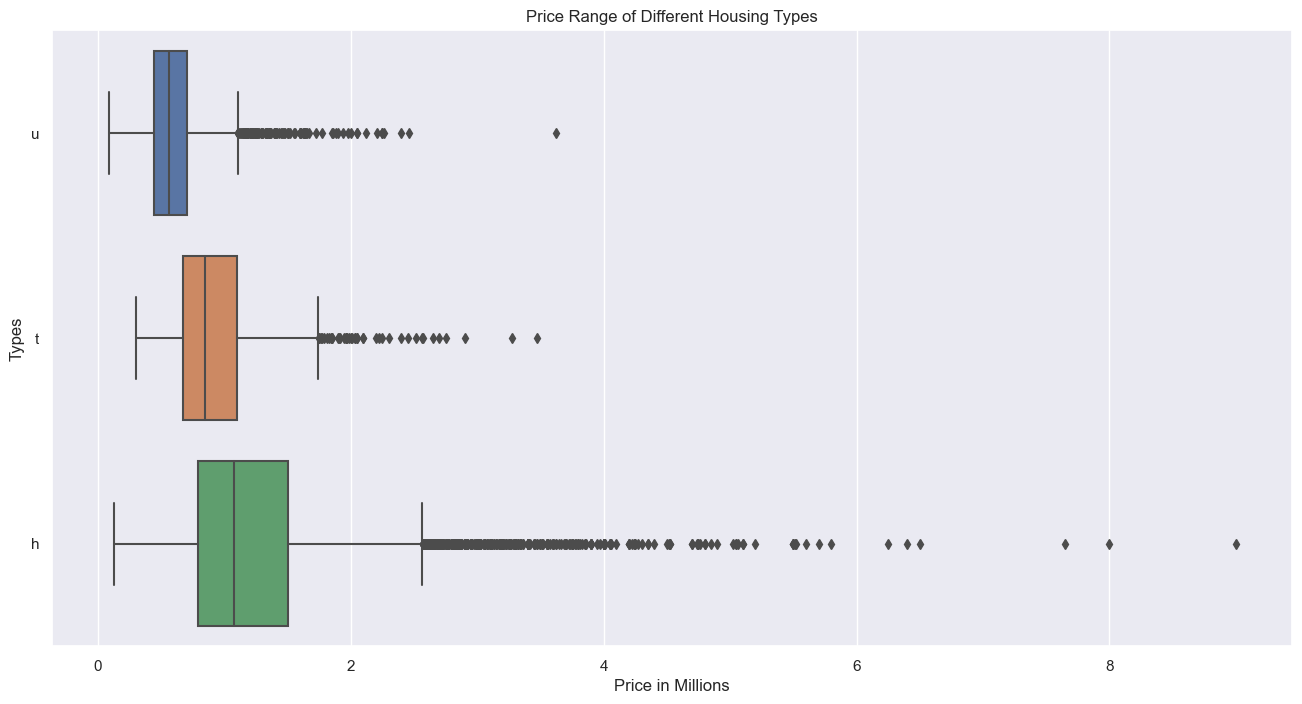

In [6]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(data=df, x="Price_in_millions", y="Type", order=['u','t','h'], ax=ax)
ax.set(title='Price Range of Different Housing Types', xlabel='Price in Millions', ylabel='Types')
plt.show()

### Visualization2: Pairplot of All Numerical Features
<b>Finding1</b>: The landsize has one obvious outlier, which should be eliminated before model training.
<br>
<b>Finding2</b>: Distance - Price plot has a rough positively skewed bell curve, which means that as the distance from CBD reduces the prices increase not strictly linearly.
<br>
<b>Finding3</b>: There is no strong correlation from the graph, whhich indicates that basic linear model might result in a relatively low score.

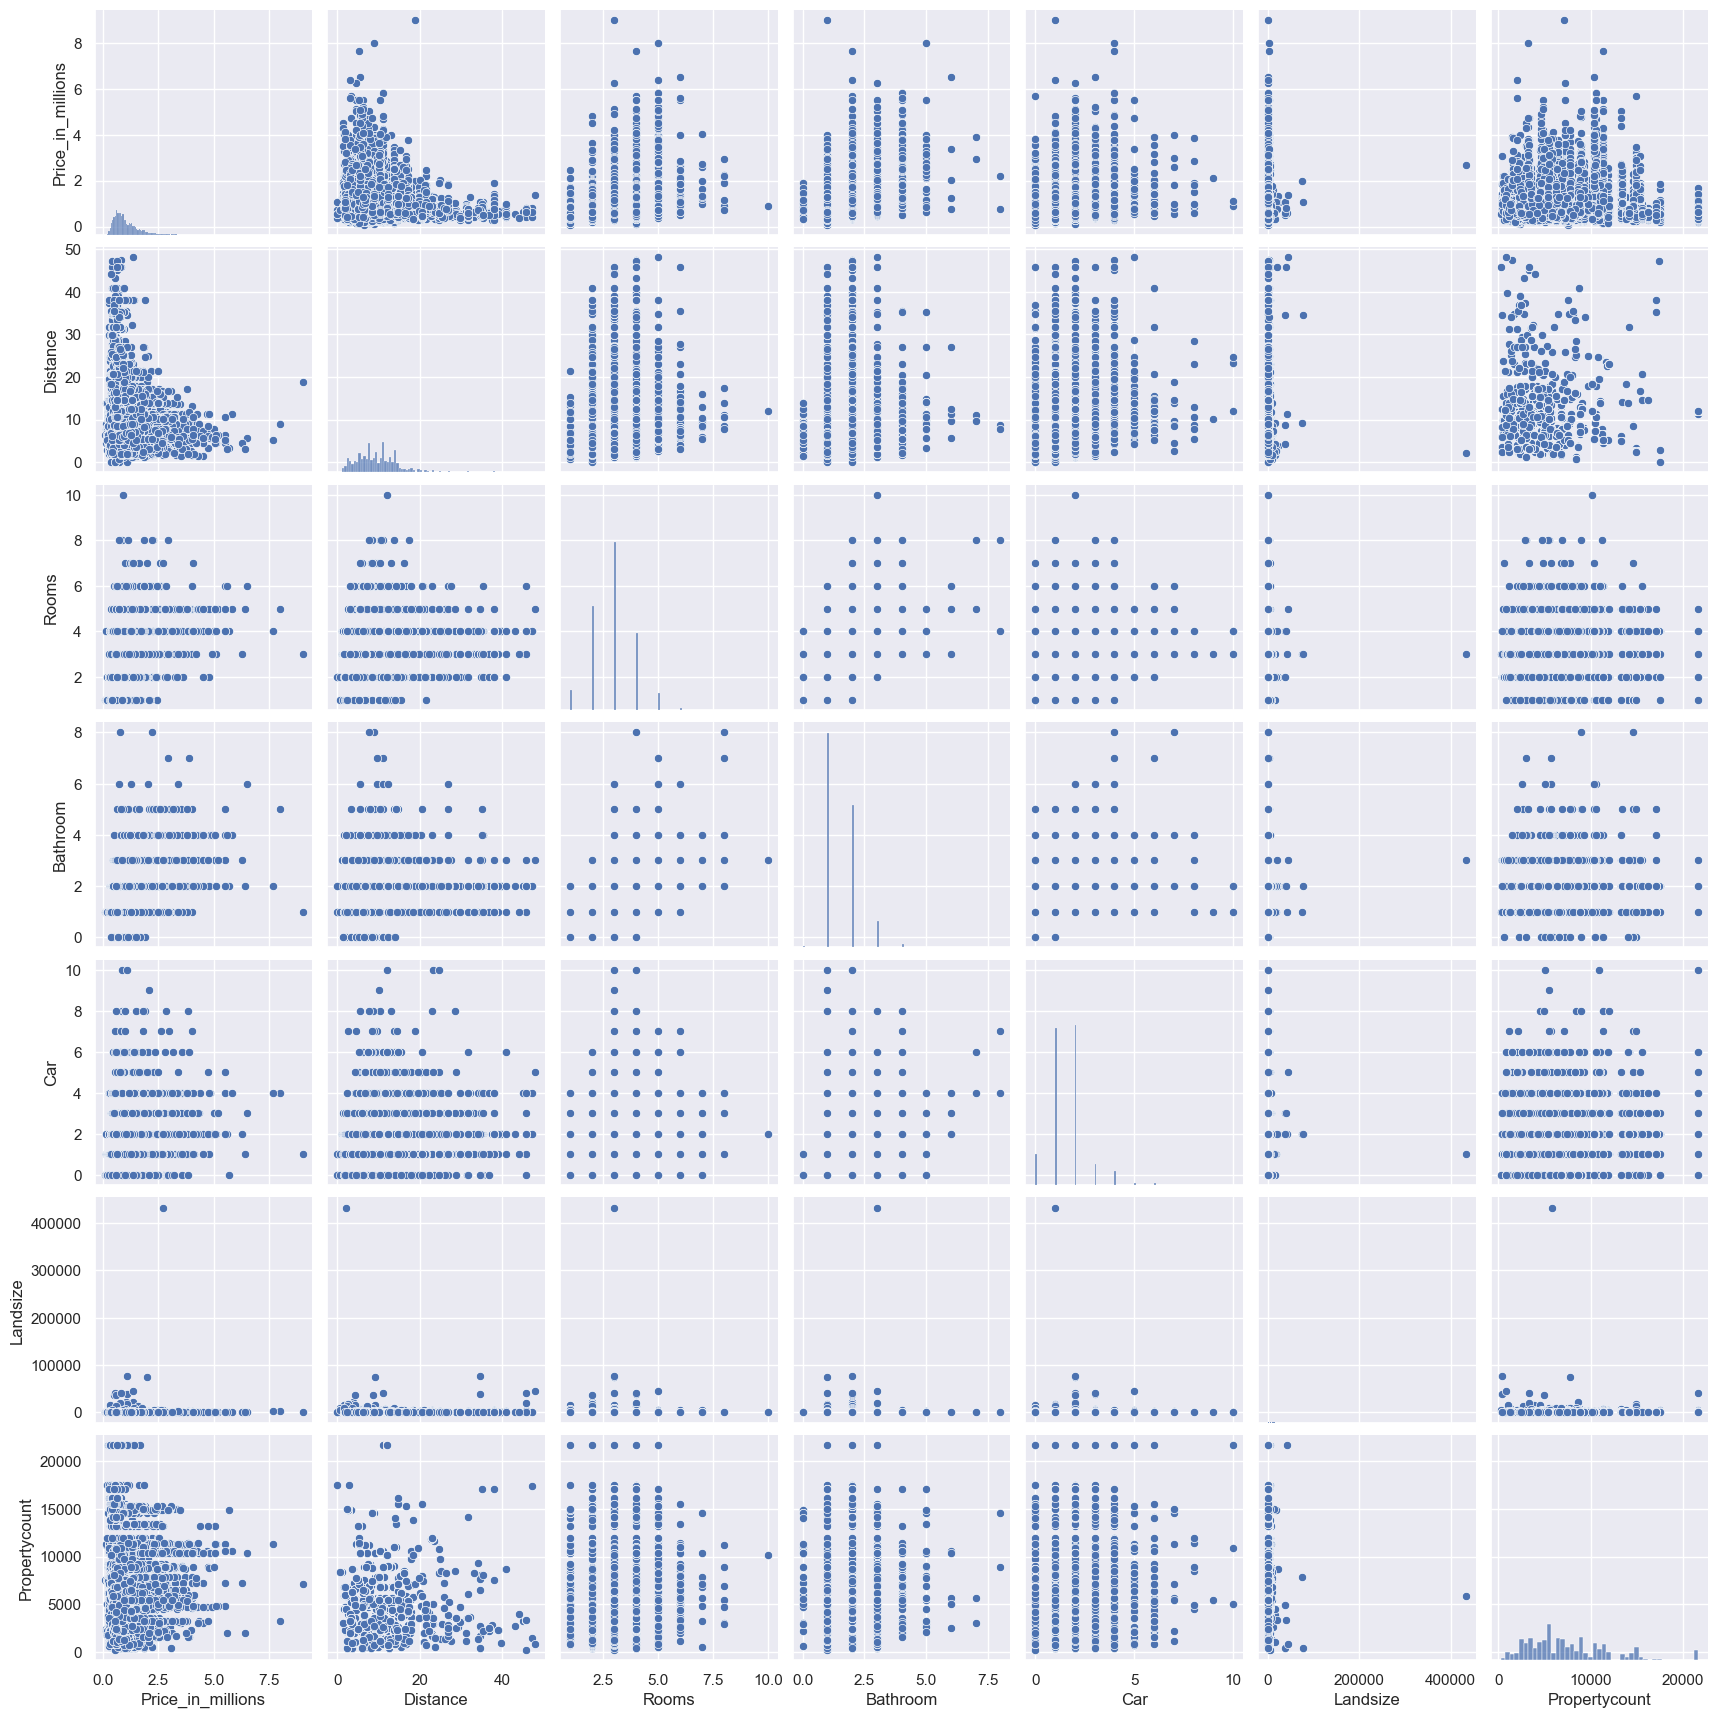

In [7]:
# extract numerical columns for correlation heatmap and pairplot
df_numerical = pd.concat([df['Price_in_millions'], df['Distance'], df['Rooms'], 
                          df['Bathroom'], df['Car'], df['Landsize'], df['Propertycount']], axis = 1)
# pairplot
sns.pairplot(df_numerical)

### Visualization3: Correlation Heatmap
Number of rooms and bathrooms have relatively high correlation with the price. Surprisingly, Distance has low correlation with price.

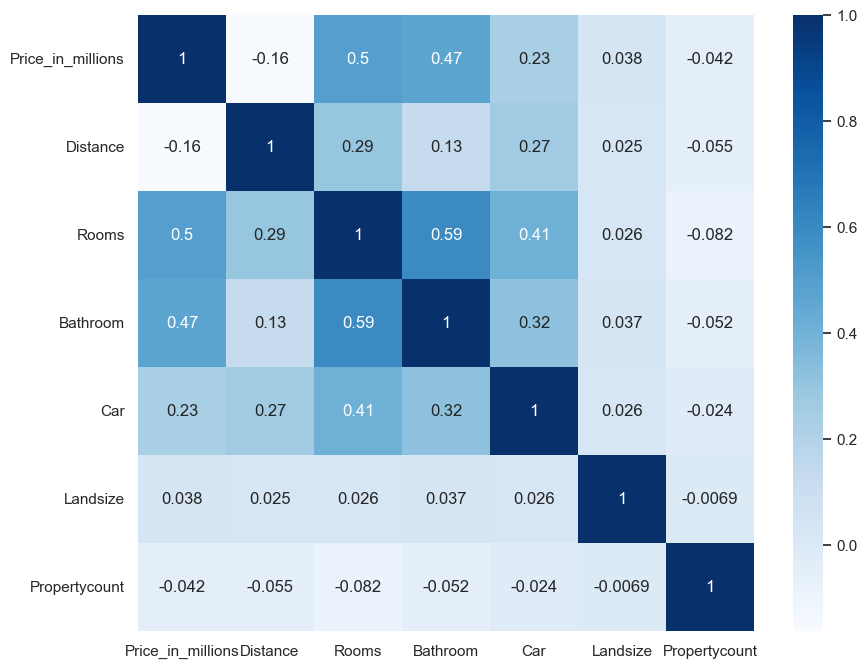

In [8]:
# correlation heatmap
fig, ax = plt.subplots(figsize=(10,8))
corr = df_numerical.corr()
sns.heatmap(corr, cmap="Blues", annot=True, square=True, ax = ax)
plt.yticks(rotation=0)
plt.show()

### Data Preprocessing before Training
After visualization, data is processed in the following steps:
* The data point with landsize outlier is removed.
* Unnecessary columns are dropped.
* One-Hot encode for categorical columns.

In [9]:
df = df.drop([df['Landsize'].argmax()])
df = df.drop(columns=['Suburb', 'Address', 'Date', 'Postcode', 'Lattitude',
                     'Longtitude', 'Propertycount', 'SellerG'])
df = pd.get_dummies(df, columns=['Type', 'Method', 'Regionname'], 
                    prefix=['Type', 'Method', 'Regionname'])
df.head()

,Rooms,Distance,Bathroom,Car,Landsize,Price_in_millions,Type_h,Type_t,Type_u,Method_PI,...,Method_SP,Method_VB,Regionname_Eastern Metropolitan,Regionname_Eastern Victoria,Regionname_Northern Metropolitan,Regionname_Northern Victoria,Regionname_South-Eastern Metropolitan,Regionname_Southern Metropolitan,Regionname_Western Metropolitan,Regionname_Western Victoria
0,2,2.5,1,1,202.0,1.480,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,2,2.5,1,0,156.0,1.035,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,3,2.5,2,0,134.0,1.465,1,0,0,0,...,1,0,0,0,1,0,0,0,0,0
3,3,2.5,2,1,94.0,0.850,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,4,2.5,1,2,120.0,1.600,1,0,0,0,...,0,1,0,0,1,0,0,0,0,0


## 2. Model Training
### Train Test Split
Before training, the data is splitted into training and testing sets using `sklearn`. 

In [10]:
# Split data into training and testing data
X = df.drop(columns=['Price_in_millions'])
y = df['Price_in_millions']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 2.1 Supervised Learning
### 2.1.1 Linear Regression

In [11]:
lr = LinearRegression()

#cross-validation on training set
lr_score_train = -1 * cross_val_score(lr, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10)
print(f'Linear Regression mean RMSE for training: {np.mean(lr_score_train)}')

lr.fit(X_train, y_train)
# predict on the testing data
y_test_pred_lr = lr.predict(X_test) 
print('Linear Regression RMSE for testing:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred_lr)))

Linear Regression mean RMSE for training: 0.41201624755106414
Linear Regression RMSE for testing: 0.41047694976909604


#### Linear Regression Feature Importance
The coefficients associated to <i>Regionname</i> and <i>Type</i> play important roles in predicting the target price. Different regions shows totally different effects on price. For example, region of Eastern Victoria and type housing have positive effect on price, but region of Western Metropilitan and type unit have negative effect on price.

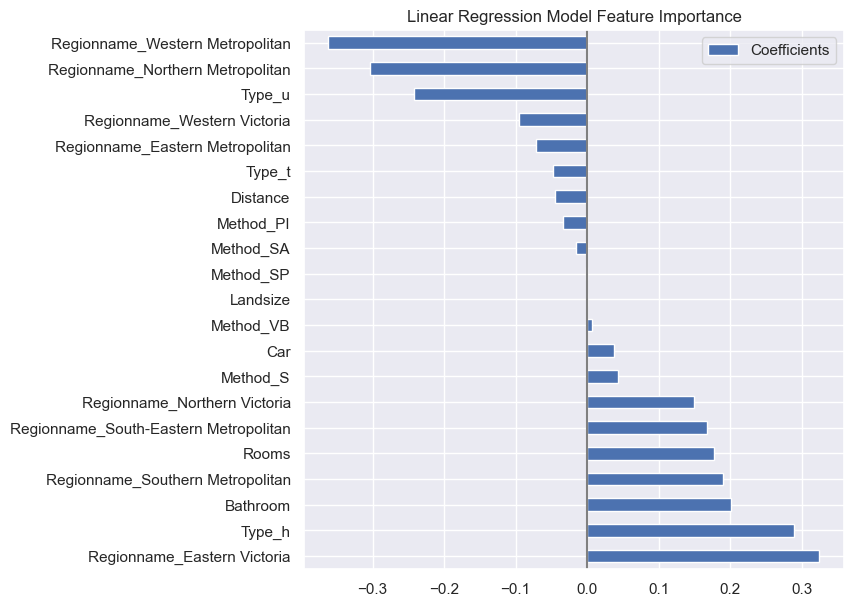

In [12]:
coefs = pd.DataFrame(
   lr.coef_,
   columns=['Coefficients'], index=X_train.columns
).sort_values(by=['Coefficients'], ascending=False)

coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Linear Regression Model Feature Importance')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

### 2.1.2 Random Forest Regression
* num of trees: 32
* number of features: all features
* maximum depth of the tree: 50

In [13]:
rfr = RandomForestRegressor(n_estimators = 32, 
                            max_features='auto',
                            max_depth = 50)

# cross validation on training set
rf_score_train = -1 * cross_val_score(rfr, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10)
print(f'Random Forest mean RMSE for training: {np.mean(rf_score_train)}')

rfr.fit(X_train, y_train)
# predict on the test data
y_test_pred_rfr = rfr.predict(X_test) 
print('Random Forest RMSE for testing:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred_rfr)))

Random Forest mean RMSE for training: 0.33479606893390634
Random Forest RMSE for testing: 0.3286858239280782


#### Random Forest Regression Feature Importance
 Random Forest model gives different feature importance than the Linear model. In Random Forest model, <i>region of Southern Metropolitan</i> places an importance role in housing price. <i>The number of rooms</i> is also important in this model, which matches with the correlation heatmap.

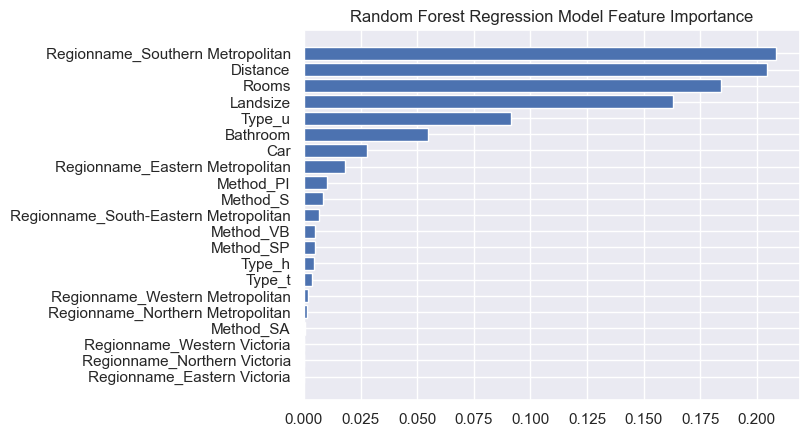

In [14]:
importances = rfr.feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots()
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(X_train.columns)[indices])
plt.title('Random Forest Regression Model Feature Importance')
plt.show()

### 2.1.3 XGBoost Regression
* num of boosting stages: 500
* learning rate: 0.02

In [15]:
xgb = XGBRegressor( 
    n_estimators = 500,
    learning_rate=0.02, 
    seed=7)

# cross validation on training set
xgb_score_train = -1 * cross_val_score(xgb, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10)
print(f'XGBoost mean RMSE for training: {np.mean(xgb_score_train)}')

xgb.fit(X_train, y_train)
# predict on the test data
y_test_pred_xgb = xgb.predict(X_test) 
print('XGBoost RMSE for testing:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred_xgb)))

XGBoost mean RMSE for training: 0.3100309533721374
XGBoost RMSE for testing: 0.2997276859502778


#### XGBoost Regression Feature Importance
XGBoost model returns similar feature importance with the Random Forest model. <i>Rooms</i> and <i>region of Southern Metropilitan</i> are importanct in predicting prices.

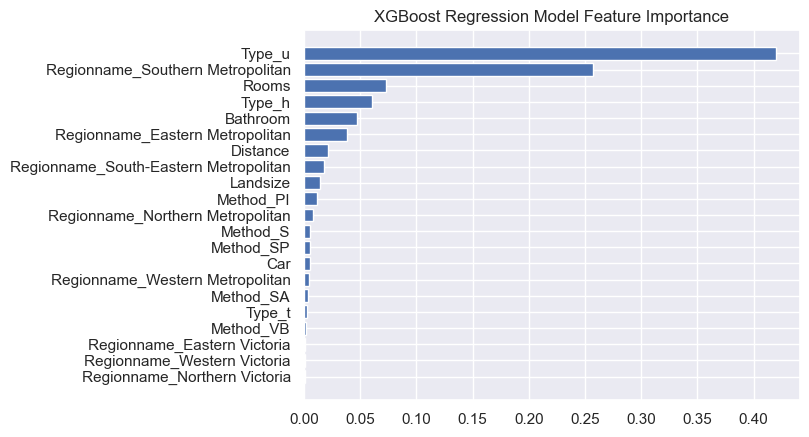

In [16]:
importances = xgb.feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots()
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(X_train.columns)[indices])
plt.title('XGBoost Regression Model Feature Importance')
plt.show()

### Supervised Learning Results
<table style="width:60%">
<tr>
<th>Score</th>
<th>Linear</th>
<th>Random Forest</th>
<th>XGBoost</th>
</tr>

<tr>
<td>Mean RMSE (train set)</td>
<td>0.41</td>
<td>0.33</td>
<td>0.31</td>
</tr>

<tr>
<td>RMSE (test set)</td>
<td>0.41</td>
<td>0.33</td>
<td>0.30</td>
</tr>
    
</table>

The <b>XGBoost model</b> outperforms the other two models with the lowest RSME score.
<br>
<b>Most Important Features</b>: <i>Rooms, Type-u, Region-Southern Metropolitan</i>

### 2.2 Unsupervised Learning
### 2.2.1 PCA
* Standardize features before running PCA using `scale()` method from `sklearn.processing` (center to mean and scale to unit variance).
* Generate principal components and determine the number of principal components for model training.

In [17]:
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)

pca = PCA()
X_train_pc = pca.fit_transform(X_train_scaled)

<b>Plot explained variance ratio for each principal component.</b>

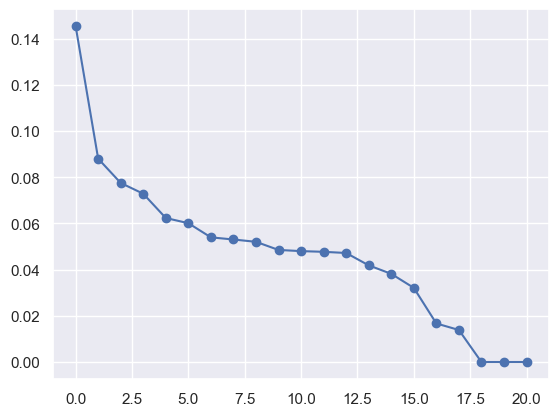

In [18]:
plt.plot(pca.explained_variance_ratio_, '-o')

<i>note: this part takes a while to run.</i>
<br>
<b>The number of principal component is determined by cross-validation and visual analysis. XGboost model is trained with iteration over increasing number of principal components, and assessed using RMSE score.</b>

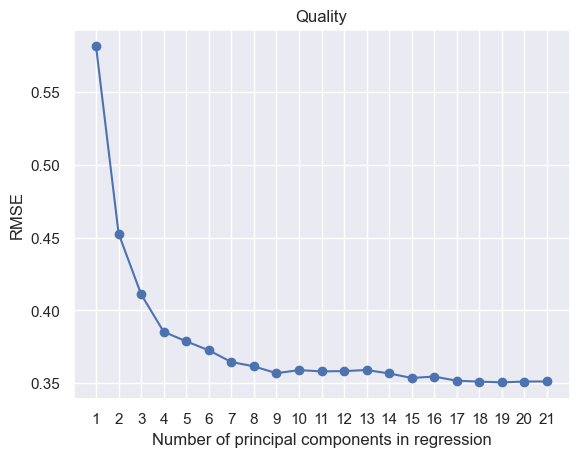

In [19]:
# Initialize Xgboost regression
xgb_after_pca = XGBRegressor( 
    n_estimators = 500,
    learning_rate=0.02, 
    seed=7)

# Create empty list to store RMSE for each iteration
rmse_list = []

# Loop through different count of principal components for XGboost regression
for i in range(1, X_train_pc.shape[1]+1):
    rmse_score = -1 * cross_val_score(xgb_after_pca, 
                                      X_train_pc[:,:i], # Use first k principal components
                                      y_train, 
                                      cv=10, 
                                      scoring='neg_root_mean_squared_error').mean()
    rmse_list.append(rmse_score)
    
# Visual analysis - plot RMSE vs count of principal components used
plt.plot(rmse_list, '-o')
plt.xlabel('Number of principal components in regression')
plt.ylabel('RMSE')
plt.title('Quality')
plt.xlim(xmin=-1);
plt.xticks(np.arange(X_train_pc.shape[1]), np.arange(1, X_train_pc.shape[1]+1))
plt.show()

<b>The training set model performance improves with more principal components, and the best performance is reached with 18 principal components. As a result, 18 is the number of principal components chosen for XGBoost model training.</b>

In [20]:
xgb_after_pca = XGBRegressor( n_estimators = 500,
                             learning_rate=0.02, 
                             seed=7)
# cross validation on training set
xgb_after_pca_score_train = -1 * cross_val_score(xgb_after_pca, X_train_pc[:,:18], y_train, 
                                                 scoring='neg_root_mean_squared_error', cv=10)
print(f'Random Forest mean RMSE for training: {np.mean(xgb_after_pca_score_train)}')

xgb_after_pca.fit(X_train_pc[:,:18], y_train)
# predict on the test data
y_test_pred_xgb_after_pca = xgb_after_pca.predict(pca.transform(X_test_scaled)[:,:18]) 
print('Random Forest RMSE for testing:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred_xgb_after_pca)))

Random Forest mean RMSE for training: 0.35098530683365736
Random Forest RMSE for testing: 0.34684017029379033


### 2.2.2 Kernel PCA
<i>note: this part takes a while to run.</i>
<br>
Polynomial kernel with degree 2 is chosen as the Kernel PCA initializer.

In [21]:
Kernel_pca = KernelPCA(kernel='poly', degree=2)
X_train_kpc = Kernel_pca.fit_transform(X_train_scaled)
X_test_kpc = Kernel_pca.transform(X_test_scaled)

xgb_after_kpca = XGBRegressor( 
    n_estimators = 500,
    learning_rate=0.02, 
    seed=7)

#cross-validation for training set
kpcr_score_train = -1 * cross_val_score(xgb_after_kpca, 
                                       X_train_kpc, 
                                       y_train, 
                                       cv=10, 
                                       scoring='neg_root_mean_squared_error')
print(f'Kernel PCR mean RMSE for training: {np.mean(kpcr_score_train)}')

xgb_after_kpca.fit(X_train_kpc, y_train)
# Predict on test data
y_test_pred_xgb_kpc = xgb_after_kpca.predict(X_test_kpc)
kpcr_score_test = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred_xgb_kpc))
print('Kernel PCR RMSE for testing:', kpcr_score_test)

Kernel PCR mean RMSE for training: 0.3451505708727762
Kernel PCR RMSE for testing: 0.35361651527686766


### Unsupervised Learning Results
<table style="width:60%">
<tr>
<th>Score</th>
<th>XGBoost after PCA</th>
<th>XGBoost after Kernel PCA</th>
</tr>

<tr>
<td>Mean RMSE (train set)</td>
<td>0.35</td>
<td>0.34</td>
</tr>

<tr>
<td>RMSE (test set)</td>
<td>0.35</td>
<td>0.35</td>
</tr>
    
</table>

XGBoost with PCA and Kernel PCA show similar performances.

## 3. Model Selection and Recommendation
PCA does not show significant improvement on model performance, so <b>XGBoost without PCA</b> is recommended for future price prediction in Melbourne, Australia. Beside this, <i>the number of rooms</i> and <i>region of Southern Metropolitan</i> should be considered the most when predicting prices, and <i>selling method</i> does not matter in final prices.

## 4. Future Improvement
#### Feature Improvement
* More features should be added to imporove model performaces, such as distance to nearest supermarket ans school
* Some of the current features were poorly sources and should be fixed in the future, such as built year

#### Model Improvement
* Refine the parameters of existing models and fix possible overfitting

#### Others
* Visualization of price trends on a map 
* More recent housing data could be added